In [1]:
import torch

In [2]:
!pip3 freeze | grep torch

torch==1.6.0
torchsummary==1.5.1
torchvision==0.7.0


In [3]:
import torch.utils.data as data
from torchvision import transforms, datasets

In [4]:
def get_celeba(root, split, download=True):
    transform = transforms.Compose([
        transforms.Resize(64),
        transforms.CenterCrop(64),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
#         transforms.Normalize(0, 1),
    ])
    return datasets.CelebA(root, split=split, transform=transform,
        download=download)

def get_data():
    dataset_train = get_celeba('~/data', 'train',)
    dataset_test = get_celeba('~/data', 'test')
    print('train', len(dataset_train))
    print('test', len(dataset_test))
    return dataset_train, dataset_test

dataset_train, dataset_test = get_data()

Files already downloaded and verified
Files already downloaded and verified
train 162770
test 19962


In [5]:
batch_size = 32
workers = 4
img_size = 64
train_data = data.DataLoader(dataset_train, batch_size=batch_size,
                             num_workers=workers, drop_last=True, shuffle=True)
test_data = data.DataLoader(dataset_test, batch_size=batch_size,
                             num_workers=workers, drop_last=True)

In [6]:
import matplotlib.pyplot as plt

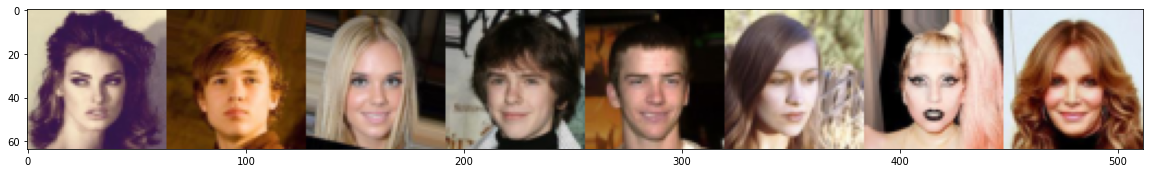

<Figure size 432x288 with 0 Axes>

In [7]:
def plot_imgs(img, save_file=False, file_name='out'):
    img = img.permute(1, 2, 0, 3).reshape(3, img_size, -1)
    img = (img + 1) / 2
    plt.figure(figsize=(20,10))
    plt.imshow(img.permute(1, 2, 0))
    plt.show()
    if save_file:
        plt.savefig(file_name)

plot_imgs(next(iter(train_data))[0][:8])

In [8]:
import torch
from torch import nn
import torch.nn.functional as F

latent_dim = 100
g_hidden = 128 # hidden dim of generator
d_hidden = 128 # hidden dim of discriminator

class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.main = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, g_hidden * 8,
                kernel_size=4, stride=1, padding=0, bias=False),
#             nn.BatchNorm2d(g_hidden * 8),
            nn.SELU(inplace=True),
            # shape is (g_hidden*8, 4, 4),

            nn.ConvTranspose2d(g_hidden * 8, g_hidden * 4,
                kernel_size=4, stride=2, padding=1, bias=False),
#             nn.BatchNorm2d(g_hidden * 4),
            nn.SELU(inplace=True),
            # shape is (g_hidden*4, 8, 8),

            nn.ConvTranspose2d(g_hidden * 4, g_hidden * 2,
                kernel_size=4, stride=2, padding=1, bias=False),
#             nn.BatchNorm2d(g_hidden * 2),
            nn.SELU(inplace=True),
            # shape is (g_hidden*2, 16, 16),

            nn.ConvTranspose2d(g_hidden * 2, g_hidden,
                kernel_size=4, stride=2, padding=1, bias=False),
#             nn.BatchNorm2d(g_hidden),
            nn.SELU(inplace=True),
            # shape is (g_hidden, 32, 32),

            nn.ConvTranspose2d(g_hidden, 3,
                kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh(),
            # shape is (3, 64, 64),
        )

    def forward(self, x):
        output = self.main(x)
        return output

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.main = nn.Sequential(
            nn.Conv2d(3, d_hidden,
                kernel_size=4, stride=2, padding=1, bias=False),
            nn.SELU(inplace=True),
            # shape is (d_hidden, 32, 32),

            nn.Conv2d(d_hidden, d_hidden * 2,
                kernel_size=4, stride=2, padding=1, bias=False),
#             nn.BatchNorm2d(g_hidden * 2),
            nn.SELU(inplace=True),
            # shape is (d_hidden * 2, 16, 16),

            nn.Conv2d(d_hidden * 2, d_hidden * 4,
                kernel_size=4, stride=2, padding=1, bias=False),
#             nn.BatchNorm2d(g_hidden * 4),
            nn.SELU(inplace=True),
            # shape is (d_hidden * 4, 8, 8),

            nn.Conv2d(d_hidden * 4, d_hidden * 8,
                kernel_size=4, stride=2, padding=1, bias=False),
#             nn.BatchNorm2d(g_hidden * 8),
            nn.SELU(inplace=True),
            # shape is (d_hidden * 8, 4, 4),

            nn.Conv2d(d_hidden * 8, 1,
                kernel_size=4, stride=1, padding=0, bias=False),
            # nn.Sigmoid()
            # shape is (1, 1, 1)
        )

    def forward(self, x):
        output = self.main(x)
        return output.view(-1, 1).squeeze(1)

def weights_init(m):
    classname = m.__class__.__name__
    if 'Conv' in classname:
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight, 1.0, 0.02)
        torch.nn.init.zeros_(m.bias)

In [9]:
def test_model():
    # test whether our model works fine
    net_d = Discriminator()
    net_g = Generator()

    x = torch.rand(16, latent_dim, 1, 1)

    out = net_g(x)
    print(out.shape)
    out2 = net_d(out)
    print(out2.shape)
test_model()

torch.Size([16, 3, 64, 64])
torch.Size([16])


In [10]:
# setting
lr = 2e-4
beta1 = 0.5
start_epoch = 1
max_epoch = 2

import os
os.makedirs('ckpts', exist_ok=True)
os.makedirs('out_imgs', exist_ok=True)

In [11]:
device = torch.device('cuda:3')

net_g = Generator().to(device)
net_g.apply(weights_init)
# print(net_g)

net_d = Discriminator().to(device)
net_d.apply(weights_init)
# print(net_g)

criterion = nn.BCEWithLogitsLoss()

optim_d = torch.optim.Adam(net_d.parameters(), lr=lr, betas=(beta1, 0.99))
optim_g = torch.optim.Adam(net_g.parameters(), lr=lr, betas=(beta1, 0.99))

In [12]:
# label setting
fixed_noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)
real_label = torch.ones(batch_size, device=device).float()
fake_label = torch.zeros(batch_size, device=device).float()

[1/2 - 0/5086] Loss_D: 0.7824 Loss_G: 21.8313


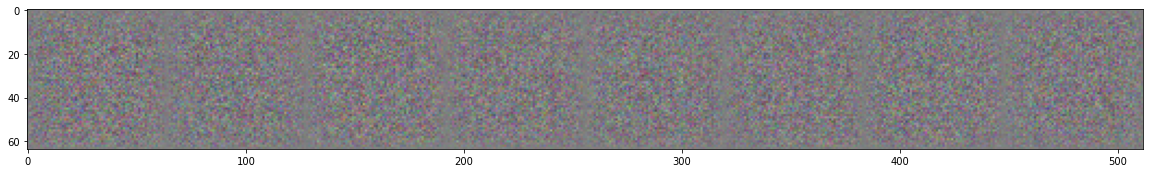

[1/2 - 508/5086] Loss_D: 0.4927 Loss_G: 4.8452


<Figure size 432x288 with 0 Axes>

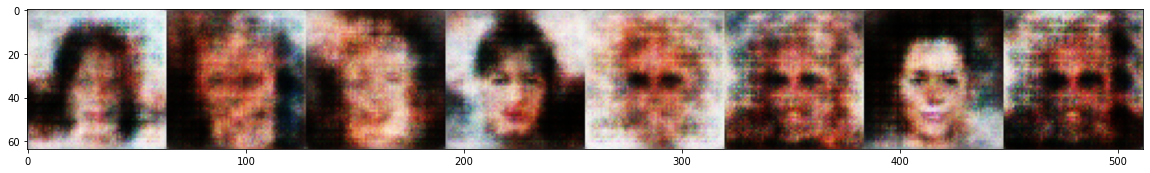

[1/2 - 1016/5086] Loss_D: 1.1162 Loss_G: 1.8385


<Figure size 432x288 with 0 Axes>

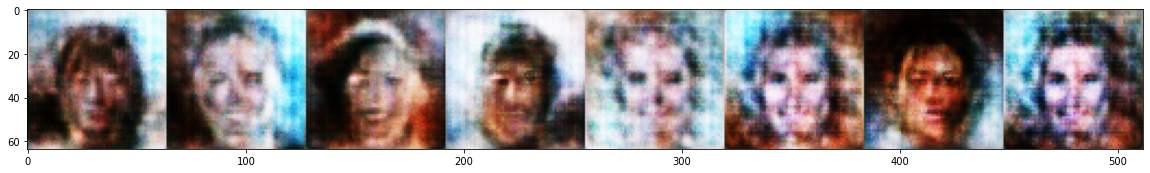

[1/2 - 1524/5086] Loss_D: 0.1939 Loss_G: 3.9907


<Figure size 432x288 with 0 Axes>

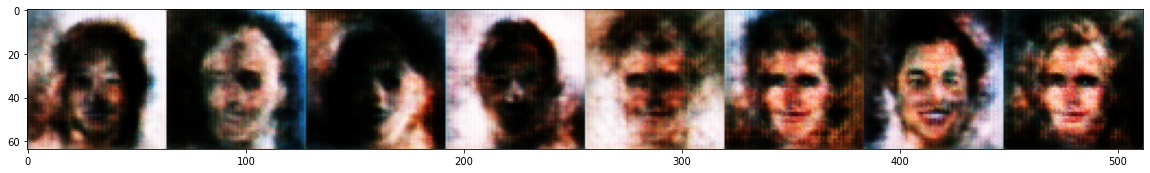

[1/2 - 2032/5086] Loss_D: 0.5911 Loss_G: 3.3525


<Figure size 432x288 with 0 Axes>

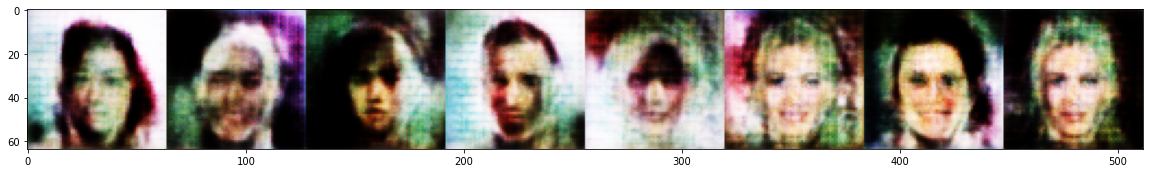

[1/2 - 2540/5086] Loss_D: 0.4082 Loss_G: 2.6607


<Figure size 432x288 with 0 Axes>

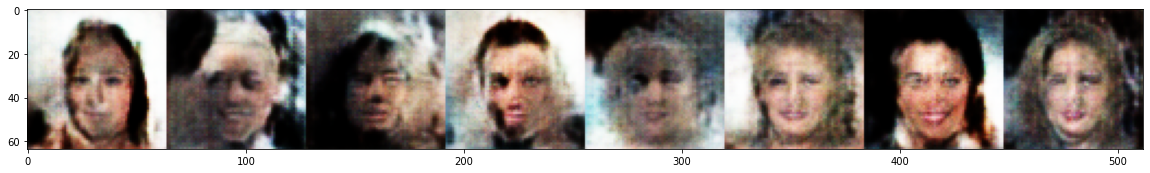

[1/2 - 3048/5086] Loss_D: 0.2748 Loss_G: 3.1354


<Figure size 432x288 with 0 Axes>

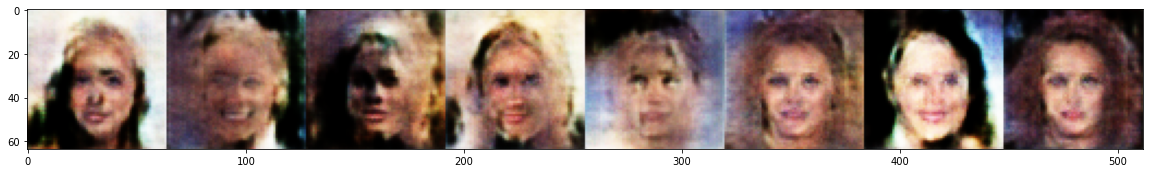

[1/2 - 3556/5086] Loss_D: 0.2717 Loss_G: 3.7254


<Figure size 432x288 with 0 Axes>

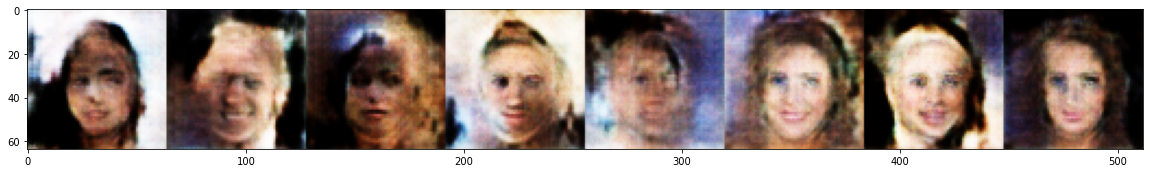

[1/2 - 4064/5086] Loss_D: 0.3018 Loss_G: 3.8592


<Figure size 432x288 with 0 Axes>

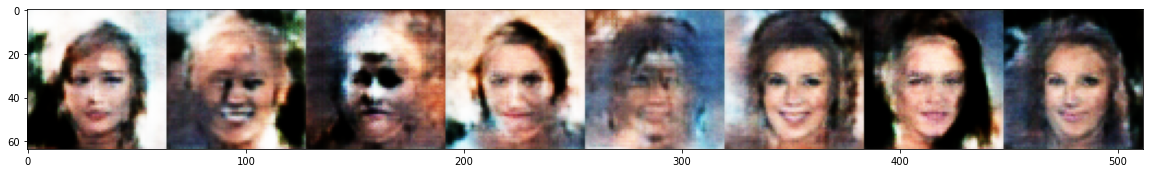

[1/2 - 4572/5086] Loss_D: 0.2669 Loss_G: 3.8014


<Figure size 432x288 with 0 Axes>

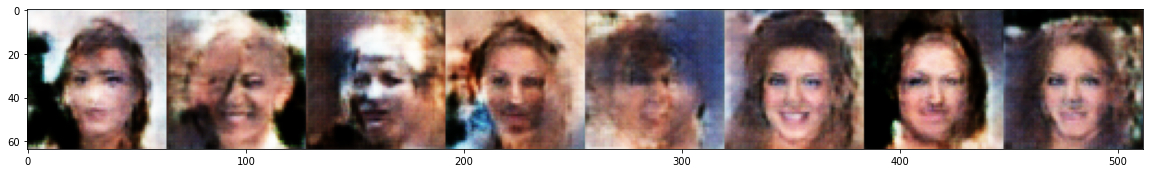

[1/2 - 5080/5086] Loss_D: 0.1746 Loss_G: 4.1485


<Figure size 432x288 with 0 Axes>

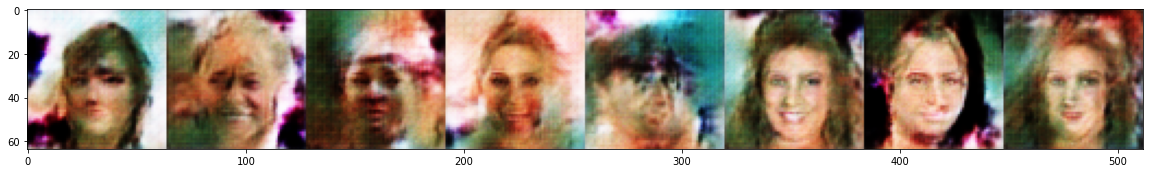

------------------------------
err_d 0.24224960803985596 err_g 3.618523597717285
[2/2 - 0/5086] Loss_D: 0.3657 Loss_G: 4.4385


<Figure size 432x288 with 0 Axes>

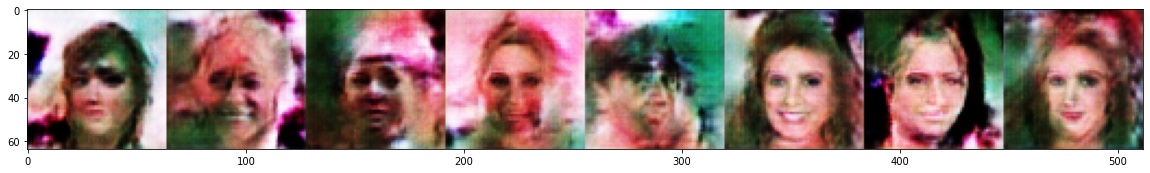

[2/2 - 508/5086] Loss_D: 0.5650 Loss_G: 2.6451


<Figure size 432x288 with 0 Axes>

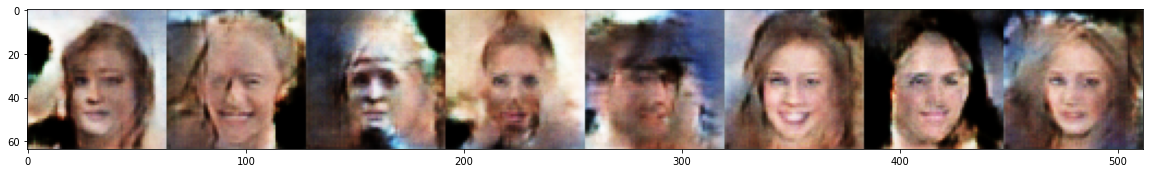

[2/2 - 1016/5086] Loss_D: 0.4008 Loss_G: 4.0038


<Figure size 432x288 with 0 Axes>

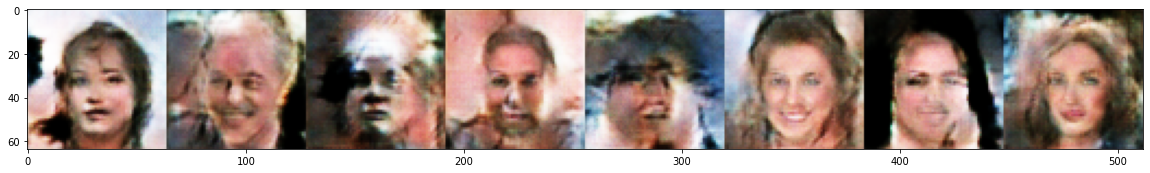

[2/2 - 1524/5086] Loss_D: 0.3726 Loss_G: 3.6883


<Figure size 432x288 with 0 Axes>

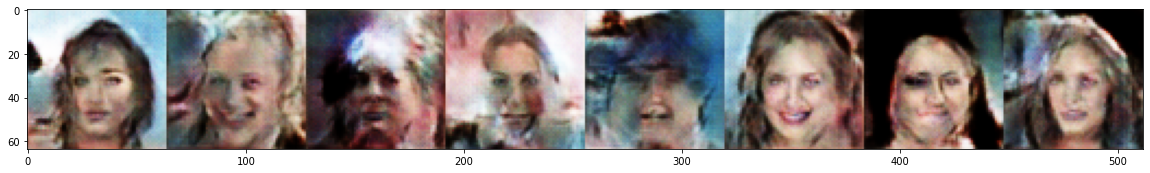

[2/2 - 2032/5086] Loss_D: 0.2807 Loss_G: 4.6555


<Figure size 432x288 with 0 Axes>

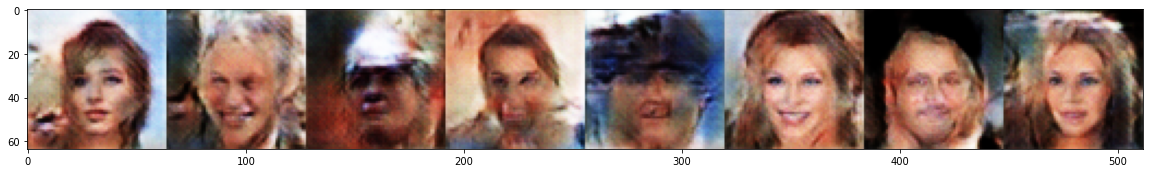

[2/2 - 2540/5086] Loss_D: 0.3034 Loss_G: 4.3179


<Figure size 432x288 with 0 Axes>

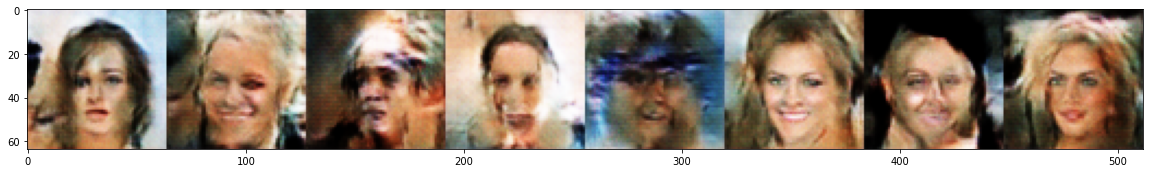

[2/2 - 3048/5086] Loss_D: 0.2158 Loss_G: 4.5153


<Figure size 432x288 with 0 Axes>

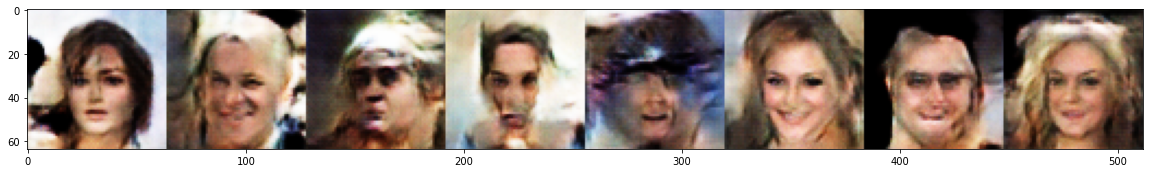

[2/2 - 3556/5086] Loss_D: 0.3327 Loss_G: 5.2248


<Figure size 432x288 with 0 Axes>

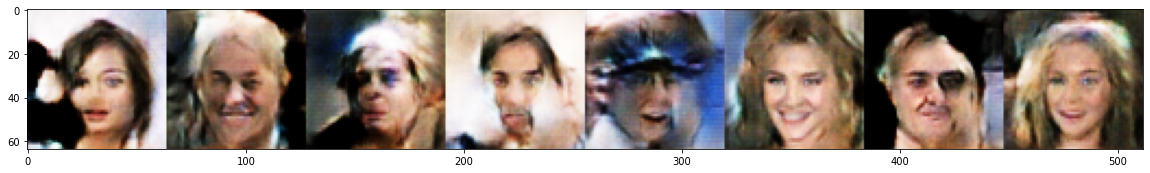

[2/2 - 4064/5086] Loss_D: 0.3651 Loss_G: 4.4625


<Figure size 432x288 with 0 Axes>

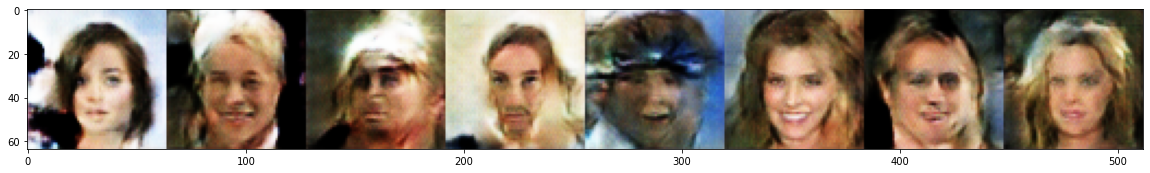

[2/2 - 4572/5086] Loss_D: 0.3862 Loss_G: 2.8517


<Figure size 432x288 with 0 Axes>

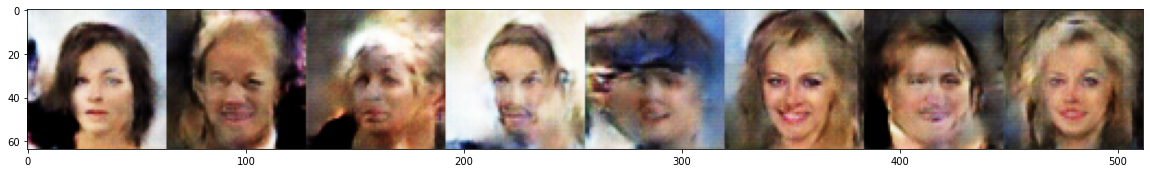

[2/2 - 5080/5086] Loss_D: 0.2940 Loss_G: 6.1166


<Figure size 432x288 with 0 Axes>

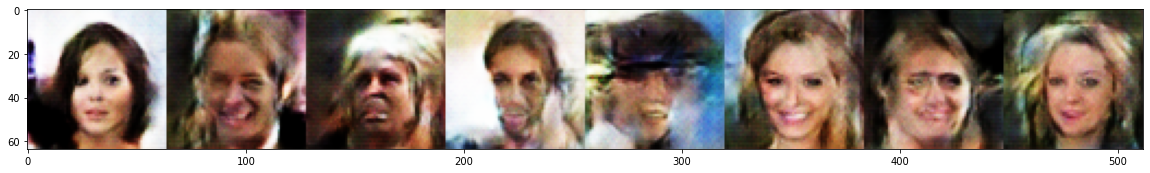

------------------------------
err_d 0.25314855575561523 err_g 5.948991298675537
avg loss d 0.25314855575561523
avg loss d 5.948991298675537
avg time 445.79705452919006 secs


<Figure size 432x288 with 0 Axes>

In [13]:
from tqdm import tqdm
import time

log_step = int(len(train_data) * 0.1)
t = time.time()

for epoch in range(start_epoch, max_epoch + 1):
    loader = enumerate(train_data)
    # loader = tqdm(loader, total=len(train_data)) # if wanna use tqdm
    d_loss_list = []
    g_loss_list = []
    for i, (imgs, _) in loader:
        loss_temp = {
            'err_d': [],
            'err_g': []
        }
        imgs = imgs.to(device)
        
        # ========== Update Discriminator ==========
        net_d.zero_grad()
        
        # throw real image into discirminator
        real_imgs = imgs.to(device)
        y_real_d = net_d(real_imgs)

        # generate fake image and throw into discirminator
        noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)
        fake_imgs = net_g(noise)
        y_fake_d = net_d(fake_imgs.detach())
        
        # update
        err_d = (
            criterion(y_real_d - torch.mean(y_fake_d), real_label) + 
            criterion(y_fake_d - torch.mean(y_real_d), fake_label)
        ) / 2
        err_d.backward()
        loss_temp['err_d'].append(err_d.item())
        optim_d.step()
        
        # ========== Update Generator ==========
        net_g.zero_grad()
        
        # throw real image into discirminator
#         real_imgs = imgs.to(device)
        y_real_g = net_d(real_imgs)
        
#         throw fake image into discirminator
#         noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)
#         fake_imgs = net_g(noise)
        y_fake_g = net_d(fake_imgs) # re-generate with no detach()
        
        # update
        err_g = (
            criterion(y_real_g - torch.mean(y_fake_g), fake_label) + 
            criterion(y_fake_g - torch.mean(y_real_g), real_label)
        ) / 2
        err_g.backward()
        loss_temp['err_g'].append(err_g.item())
        optim_g.step()
        
        if i % log_step == 0:
            print('[{}/{} - {}/{}] Loss_D: {:.4f} Loss_G: {:.4f}'.format( # y_d: {:.4f} / {:.4f}
                epoch, max_epoch, i, len(train_data),
                err_d.item(), err_g.item(),# y_d_real, y_d_fake#, y_g_real, y_g_fake
            ))

            fix_fake_imgs = net_g(fixed_noise).cpu().detach()
            plot_imgs(fix_fake_imgs[:8], True, file_name='out_imgs/e{:02}.png'.format(epoch))
            
#     torch.save({'net_d': net_d.state_dict(), 'net_g': net_g.state_dict(),
#         'epoch': epoch, 'optim_d': optim_d.state_dict(), 'optim_g': optim_g.state_dict()
#     }, 'ckpts/dcgan_epoch_{:02d}.pt'.format(epoch))
    
    print('-' * 30)
    l_d = sum(loss_temp['err_d']) / len(loss_temp['err_d'])
    l_g = sum(loss_temp['err_g']) / len(loss_temp['err_g'])
    print('err_d', l_d, 'err_g', l_g)
    d_loss_list.append(l_d)
    g_loss_list.append(l_g)
print('avg loss d', sum(d_loss_list) / len(d_loss_list))
print('avg loss d', sum(g_loss_list) / len(g_loss_list))
t = time.time() - t
print('avg time', t / max_epoch, 'secs')

In [14]:
print('avg loss d', sum(d_loss_list) / len(d_loss_list))
print('avg loss d', sum(g_loss_list) / len(g_loss_list))
t = time.time() - t
print('avg time', t / max_epoch, 'secs')

avg loss d 0.25314855575561523
avg loss d 5.948991298675537
avg time 803724574.3283703 secs


In [15]:
# https://github.com/AlexiaJM/Deep-learning-with-cats